In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [20, 40]

In [2]:
data_set = pd.read_csv("../data/Google_Stock_Price_Train.csv")
print(data_set.head())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


- Data preprocesing

------

In [3]:
data_set.shape

(1258, 6)

In [4]:
data_set = data_set.iloc[:,1:4].values
data_set

array([[325.25, 332.83, 324.97],
       [331.27, 333.87, 329.08],
       [329.83, 330.75, 326.89],
       ...,
       [793.7 , 794.23, 783.2 ],
       [783.33, 785.93, 778.92],
       [782.75, 782.78, 770.41]])

In [5]:
data_set = np.array([[i,j-k]for i,j,k in data_set])
data_set

array([[325.25,   7.86],
       [331.27,   4.79],
       [329.83,   3.86],
       ...,
       [793.7 ,  11.03],
       [783.33,   7.01],
       [782.75,  12.37]])

Target interval = 1

In [6]:
X_data = data_set[0:1257]
y_data = data_set[1:1258,0:1]

In [7]:
X_sc = MinMaxScaler() # default is 0,1
X_data = X_sc.fit_transform(X_data)

In [8]:
y_sc = MinMaxScaler() # default is 0,1
y_data = y_sc.fit_transform(y_data)

- x_dim =2

In [9]:
X_data

array([[0.08581368, 0.11558367],
       [0.09701243, 0.05673759],
       [0.09433366, 0.03891125],
       ...,
       [0.95163331, 0.16043703],
       [0.95725128, 0.17634656],
       [0.93796041, 0.09929078]])

In [10]:
y_data

array([[0.09701243],
       [0.09433366],
       [0.09156187],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [11]:
# hyperparameters
seq_length =7
batch_size =35
state_size = 4 # hidden node size 
input_dim = X_data.shape[1] # 2
output_dim = y_data.shape[1] # 1

In [12]:
print('# of paired dataset', len(y_data)-seq_length)

# of paired dataset 1250


In [13]:
data_X = []
data_y = []
for i in range(0, len(y_data) - seq_length):
    _X_data = X_data[i:i+seq_length]
    _y_data = y_data[i+seq_length]
    data_X.append(_X_data)
    data_y.append(_y_data)
    if i%1000 ==0:
        print(_X_data, "->", _y_data)

[[0.08581368 0.11558367]
 [0.09701243 0.05673759]
 [0.09433366 0.03891125]
 [0.09156187 0.06248802]
 [0.07984225 0.21084915]
 [0.0643277  0.12631781]
 [0.0585423  0.04389496]] -> [0.06109085]
[[0.88241313 0.16062871]
 [0.87512092 0.0555875 ]
 [0.88138998 0.22311673]
 [0.90700573 0.22465018]
 [0.92544088 0.17002108]
 [0.91223305 0.17883841]
 [0.86293623 0.2102741 ]] -> [0.83875288]


In [14]:
X_trn, X_tst, y_trn, y_tst = train_test_split(data_X, data_y, 
                                              test_size=0.3, 
                                              random_state=42,
                                              shuffle=False
                                              )
print('X_train:', len(X_trn))
print('y_train:', len(y_trn))
print('X_test:', len(X_tst))
print('y_test:', len(y_tst))

X_train: 875
y_train: 875
X_test: 375
y_test: 375


- graph로 통과시킬 변수 선언

In [15]:
X = tf.placeholder(tf.float32, [None, seq_length, input_dim])
y = tf.placeholder(tf.float32, [None, 1])
lr = tf.placeholder(tf.float32)

In [16]:
print(X)
print(y)

Tensor("Placeholder:0", shape=(?, 7, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [17]:
init_state = tf.placeholder(tf.float32, [None, state_size])
init_state

<tf.Tensor 'Placeholder_3:0' shape=(?, 4) dtype=float32>

- 학습되는 파라미터 선언

In [18]:
# hidden state
# concat trainables weights = state_dim + input dim 
W = tf.Variable(np.random.rand(state_size+input_dim, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

# output
W2 = tf.Variable(np.random.rand(state_size, output_dim),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,output_dim)), dtype=tf.float32)

In [19]:
print(W)
print(b)

<tf.Variable 'Variable:0' shape=(6, 4) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(1, 4) dtype=float32_ref>


In [20]:
print(W2)
print(b2)

<tf.Variable 'Variable_2:0' shape=(4, 1) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>


- 각 sequence마다 input을 연산하기 위해 split적용

 $ X \in \mathbb{R}^{?\times 7 \times 2} \rightarrow \{ \mathbb{R}^{?\times 1 \times 2} \}^7$

In [21]:
inputs_series = tf.split(value=X, num_or_size_splits=seq_length, axis=1)
inputs_series

[<tf.Tensor 'split:0' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:1' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:2' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:3' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:4' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:5' shape=(?, 1, 2) dtype=float32>,
 <tf.Tensor 'split:6' shape=(?, 1, 2) dtype=float32>]

- RNN network

init_state $\in \mathbb{R}^{? \times 4}$ 

inputs_series $\in \{\mathbb{R}^{? \times 1 \times 2}\}^7$

current_input $\in \mathbb{R}^{?  \times 1 \times 2}$ 

flatten_input $\in \mathbb{R}^{?  \times 2}$ 

input_and_state_concatenated $\in \mathbb{R}^{? \times 6}$

In [23]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series: # unstacked state in each step 
    flatten_input = tf.reshape(current_input,shape=[-1,input_dim])
    input_and_state_concatenated = tf.concat(
        [flatten_input, current_state], axis=1)  # Increasing number of columns
    
    next_state = tf.tanh(tf.matmul(
        input_and_state_concatenated, W) + b)  # Broadcasted addition
    
    states_series.append(next_state)
    current_state = next_state

In [24]:
current_input

<tf.Tensor 'split:6' shape=(?, 1, 2) dtype=float32>

In [25]:
flatten_input

<tf.Tensor 'Reshape_6:0' shape=(?, 2) dtype=float32>

In [26]:
states_series

[<tf.Tensor 'Tanh:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_1:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_2:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_3:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_4:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_5:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Tanh_6:0' shape=(?, 4) dtype=float32>]

In [27]:
states_series = tf.concat([tf.expand_dims(state,1) for state in states_series], axis=1)
states_series

<tf.Tensor 'concat_7:0' shape=(?, 7, 4) dtype=float32>

- loss function

In [28]:
# with last hidden state
y_pred = tf.layers.dense(states_series[:,-1], output_dim, activation=None)
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [29]:
loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [30]:
sess = tf.Session()
init = tf.global_variables_initializer()

In [31]:
sess.run(init)

0th loss: 0.009750883094966412
1000th loss: 0.0011124557349830866
2000th loss: 0.000921538274269551
3000th loss: 0.00039736763574182987
4000th loss: 0.0004649790353141725
5000th loss: 0.000932161055970937
6000th loss: 0.00039734767051413655


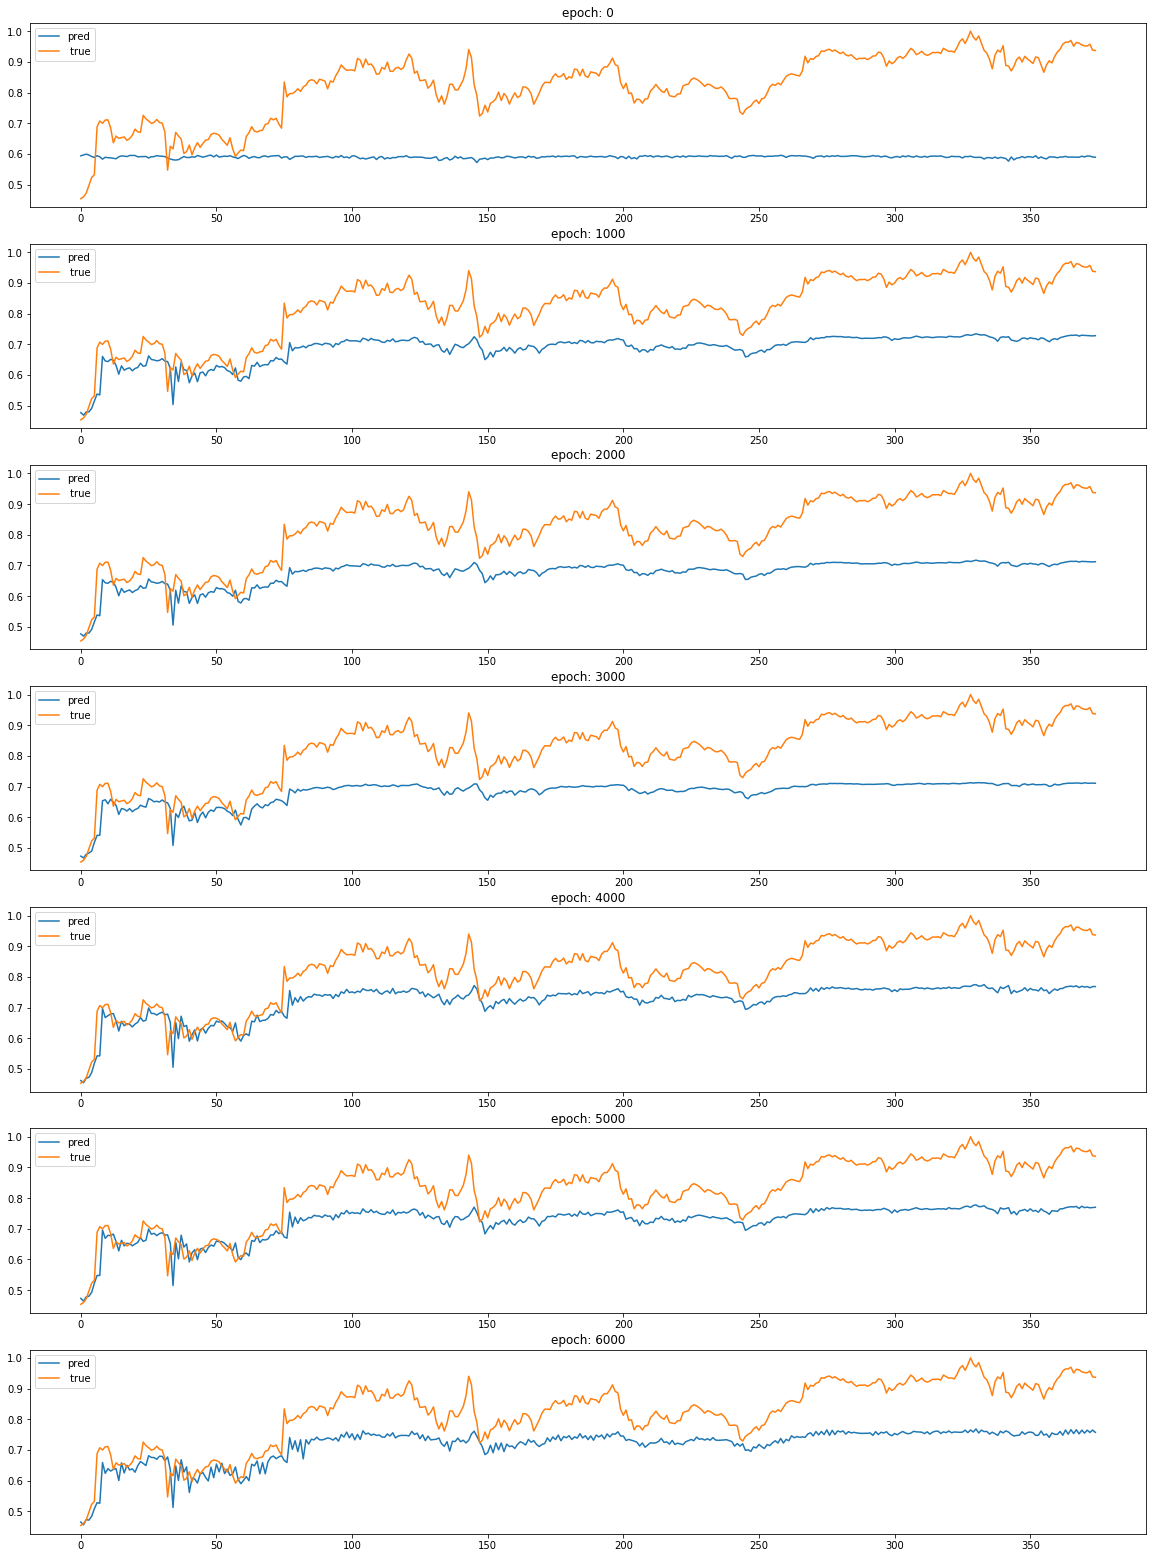

In [32]:
ix=1

for i in range(7000):
#    _current_state = np.zeros((batch_size, state_size))
    for k in range(math.ceil(len(X_trn)/batch_size)):
        start = k*batch_size
        end = (k*batch_size)+batch_size
        _ , _loss, _current_state = sess.run([train_op, loss, current_state], 
                 feed_dict={lr:0.01,
                            X: X_trn[start:end],
                            y: y_trn[start:end],
                            init_state: np.zeros((batch_size, state_size))
                           })

    if i % 1000==0:
        print('{}th loss: {}'.format(i,_loss))
        
        plt.subplot(10,1,ix)
        
        total_y_pred = []
        for k in range(math.ceil((len(X_tst)/batch_size))):
            start = k*batch_size
            end = (k*batch_size)+batch_size
       
            _y_pred = sess.run(y_pred, feed_dict={ X: X_tst[start:end],
                                                 init_state:_current_state[0:len(X_tst[start:end])]})
            total_y_pred.extend(_y_pred)
        
        total_y_pred = np.array(total_y_pred)
        
        tst_loss = np.mean(np.abs(total_y_pred-y_tst))
        plt.plot(total_y_pred, label ='pred')
        plt.plot(y_tst, label = ' true')
        plt.legend()
        plt.title('epoch: {}'.format(i))
        
        ix+=1

- y 복원예측하는 방법

In [35]:
y_sc.inverse_transform(_y_pred)[0:5]

array([[527.67865],
       [523.32074],
       [533.624  ],
       [532.45306],
       [538.89233]], dtype=float32)

In [36]:
tst_loss

0.10634635885225972

In [37]:
y_sc.inverse_transform(tst_loss)

array([[336.28754866]])

---------